In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
import pymysql
import numpy as np
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [22]:
def pickleLoad(file):
    if os.path.isfile(file):        
        with open(file,"rb") as fr:
            dataframe = pickle.load(fr)
        return dataframe
    else:  
        %run -i 'getTrainTestSet.py' 

In [23]:
# load train, test set data

X_train = pickleLoad('./dataset/X_train.pkl')
X_test = pickleLoad('./dataset/X_test.pkl')
y_train = pickleLoad('./dataset/y_train.pkl')
y_test = pickleLoad('./dataset/y_test.pkl')
ccsi = pickleLoad('./dataset/ccsi.pkl')
predictors = pickleLoad('./dataset/predictors.pkl')



## Step3. Modeling
### model 5. regression Random Forest

* model fitting

In [24]:
# grid search를 해서, 최적의 파라미터를 갖는 트리 모델을 적합
param_grid = {'max_features':[4, 6, 8, 10], 'n_estimators':np.power(2, [3,4,5,6]),'random_state': [23]}
model_forest = GridSearchCV( RandomForestRegressor(), param_grid, cv = 5, scoring = 'neg_mean_squared_error', return_train_score = True)

model_forest.fit(X_train, y_train)
print(model_forest.best_params_)

{'max_features': 6, 'n_estimators': 32, 'random_state': 23}


* prediction

In [25]:
y_pred = model_forest.predict(X_test) # y_pred: test set을 넣어서 얻은 예측 값
y_pred

array([100.19375 , 107.196875, 109.015625, 107.34375 , 100.49375 ,
       108.615625,  94.06875 ,  78.675   ,  85.39375 , 102.38125 ,
        98.146875,  74.35625 ])

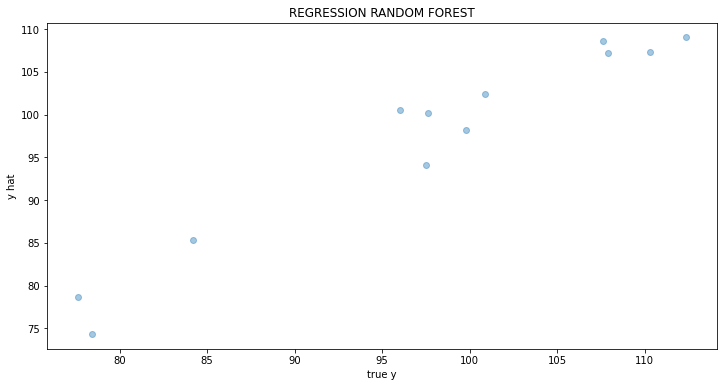

In [26]:
# test set에 대한 실제값과 예측 값의 추세 확인
plt.scatter(y_test, y_pred, alpha=0.4)
plt.xlabel("true y")
plt.ylabel("y hat")
plt.title("REGRESSION RANDOM FOREST")
plt.show()

* model evaluating

In [27]:
print("training RMSE: ", np.sqrt(-model_forest.best_score_))
print("test RMSE: ", np.sqrt(-model_forest.score(X_test, y_test)))

training RMSE:  4.644123005899348
test RMSE:  2.650056504900726


## Step4. Validate
여러 모델들을 비교 평가

## Step5. Visualization
### weekly record 예측하기(weekly CCSI)

In [28]:
# weekly 레코드들을 예측 모델에 집어넣어, 각 레코드에 대한 예측값 얻음
pred_ccsi = model_forest.predict(predictors[['keyword1','keyword2','keyword3','keyword4','keyword5','google','naver']])

In [29]:
tmp = pd.merge(predictors, ccsi).drop(['id'], axis=1)
tmp['pred'] = pred_ccsi
tmp.head()

,year,month,day,keyword1,keyword2,keyword3,keyword4,keyword5,google,naver,ccsi,pred
0,2016,1,4,825,419,437,986,168,53.0,26.05846,99.5,95.853125
1,2016,1,11,770,348,351,626,182,58.0,25.16599,99.5,97.325000
2,2016,1,18,918,422,441,445,147,74.0,27.38639,99.5,93.556250
3,2016,1,25,1067,425,567,383,148,59.0,24.72622,99.5,95.053125
4,2016,2,1,899,341,485,289,110,63.0,23.01888,97.2,94.596875


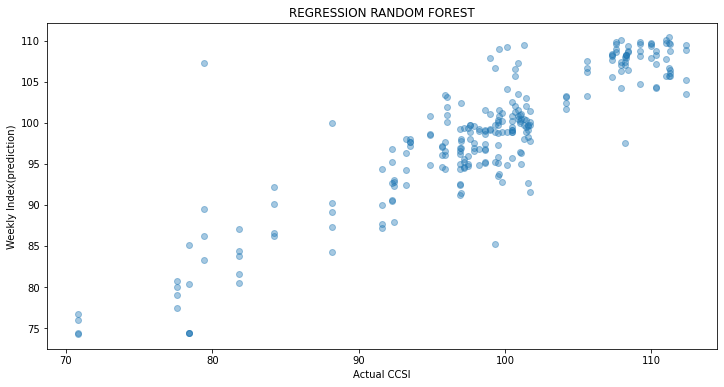

In [30]:
# true와 pred의 추세 확인
plt.scatter(tmp['ccsi'], tmp['pred'], alpha=0.4)
plt.xlabel("Actual CCSI")
plt.ylabel("Weekly Index(prediction)")
plt.title("REGRESSION RANDOM FOREST")
plt.show()

In [31]:
# weekly별 단기지표 값에 대한 RMSE
print("RMSE about weekly CCSI: ", np.sqrt(mean_squared_error(tmp['ccsi'], tmp['pred'])))

RMSE about weekly CCSI:  4.038796073233722


### visualization
* 시계열 그래프

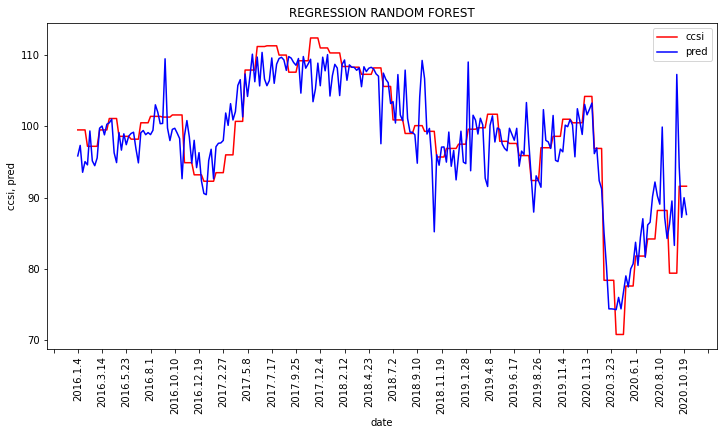

In [32]:
# 시계열 그래프를 그리기위해, 날짜 column 생성
tmp['date'] = tmp[['year', 'month', 'day']].apply(lambda x: '.'.join(map(str, x)), axis=1)

plt.rcParams["figure.figsize"] = (12, 6)
plt.plot(tmp['date'], tmp['ccsi'], color = 'red', label = 'ccsi')
plt.plot(tmp['date'], tmp['pred'], color = 'blue', label = 'pred')
plt.xlabel("date")
plt.ylabel("ccsi, pred")
ax = plt.subplot()
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
for label in ax.xaxis.get_ticklabels() :
    label.set_rotation(90)
plt.title("REGRESSION RANDOM FOREST")
plt.legend()
plt.show()

* moving avg 시계열 그래프

2주 간의 단기 지표들을 평균낸 값을 weekly CCSI로 활용하고자함. <br>
시각화 결과, 주간 레코드에 대한 예측 결과를 바로 활용하는 것 보다 2주 간의 예측 결과 평균을 활용하는 것이 덜 들쑥날쑥하다.

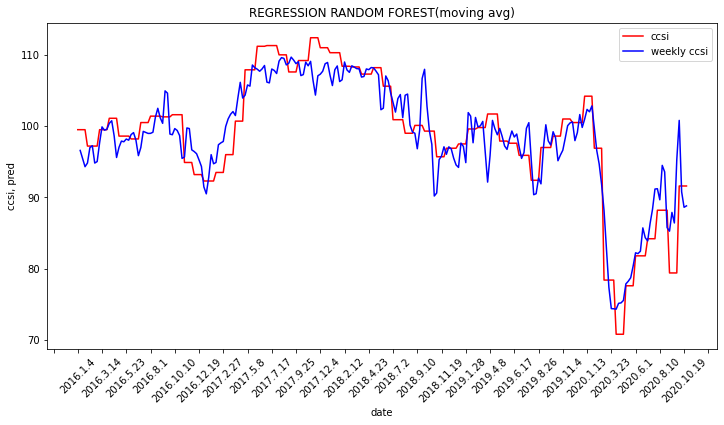

In [33]:
rolling = pd.Series.rolling(tmp['pred'], window = 2, center = False).mean()

plt.rcParams["figure.figsize"] = (12, 6)
plt.plot(tmp['date'], tmp['ccsi'], color = 'red', label = 'ccsi')
rolling.plot(color = 'blue', label = 'weekly ccsi')
plt.xlabel("date")
plt.ylabel("ccsi, pred")
ax = plt.subplot()
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
for label in ax.xaxis.get_ticklabels() :
    label.set_rotation(45)
plt.title("REGRESSION RANDOM FOREST(moving avg)")
plt.legend()
plt.show()

## Step6. Develop weekly CCSI(주간 경기선행지수)

In [34]:
weekly_CLI = []
for i in range(len(tmp)):
    if i == 0 :
        cli = tmp.pred.iloc[i]
        weekly_CLI.append(cli)
        continue
    
    cli = (tmp.pred.iloc[i-1] + tmp.pred.iloc[i]) / 2
    weekly_CLI.append(cli)
    
tmp['weeklyCLI'] = weekly_CLI
tmp

,year,month,day,keyword1,keyword2,keyword3,keyword4,keyword5,google,naver,ccsi,pred,date,weeklyCLI
0,2016,1,4,825,419,437,986,168,53.0,26.05846,99.5,95.853125,2016.1.4,95.853125
1,2016,1,11,770,348,351,626,182,58.0,25.16599,99.5,97.325000,2016.1.11,96.589062
2,2016,1,18,918,422,441,445,147,74.0,27.38639,99.5,93.556250,2016.1.18,95.440625
3,2016,1,25,1067,425,567,383,148,59.0,24.72622,99.5,95.053125,2016.1.25,94.304688
4,2016,2,1,899,341,485,289,110,63.0,23.01888,97.2,94.596875,2016.2.1,94.825000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,2020,9,28,489,90,114,95,78,63.0,25.29102,79.4,107.281250,2020.9.28,95.289062
248,2020,10,5,816,183,177,109,78,81.0,28.63240,91.6,94.325000,2020.10.5,100.803125
249,2020,10,12,857,199,176,112,91,82.0,26.85177,91.6,87.234375,2020.10.12,90.779687
250,2020,10,19,911,155,143,95,129,93.0,27.25273,91.6,89.990625,2020.10.19,88.612500
